In [29]:
import os
import numpy as np
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d, Axes3D

#To make the notebook's output stabel across runs
np.random.seed(42)

#Uses Jupyter's own backend to plot
%matplotlib inline

#To make pretty figures
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

#Path to saving images
IMAGE_PATH = os.path.join("images")
os.makedirs(IMAGE_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True , fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

***Curse of dimensionality*** happens when the number of features for training instances are very large, thousands or even millions. Thus, these features makes training extremely slow and make it much harder to find a good solution

It's possible to reduce the amount of feature considerably. For instance, in the MNIST images: the pixels on the image borders are almost always white, so we can drop them without losing too much information. Moreover, two neighboring pixels are often highly correlated: so you can merge them into a single pixel (by taking the mean of the two pixel intensities) and not lose too much information

> Reducing dimensionality does cause information loss, so even though it will speed up training, it may make the system perform slightly worse. Also, it makes your pipelines a bit more complex and thus harder to maintain. So, if training is too slow, you should first try to train your system with the original data before considering using dimensionality reduction

Dimensionality reduction is extremely useful for data visualization (DataViz). Reducing the number of dimensions down to two/three makes it possible to plot a condensed view of a high-dimensional training set on a graph and often gain some **important insights by visually detecting patterns such as clusters.** Also, DataViz is **critical to communicate your conclusions to people who are not data scientist** - decision makers who will use my results.

We'll discuss the **two main approaches to dimensionality reduction: _projection_ and _Manifold Learning_**, and cover the three most popular dimensionality reduction techniques: PCA, Kerlnel PCA and LLE

# Section: The Curse Of Dimensionality

There's plenty of space in high dimensions. Thus, high dimension datasets are at risk of being very sparse, that is, most training instances are likely to be far away from each other. This also means that a new instance will likely be far away from any training instance, making predictions much less reliable that in lower dimensions, since they are based on a much larger extrapolation.

In short, the more dimensions the training set has, the greater the risk of overfitting it

In theory, one solution could be to increase the size of the training set to reach a sufficient density of training instances. **Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions. With just 100 features, the number of training instances needed is more than the atoms in the observable universe in order for training instances to be within 0.1 of each other on average, assuming they are spread out uniformly across all dimensions**

# End Of Section: The Curse Of Dimensionality

# Section: Main Approaches For Dimensionality Reduction

##### Projection

In real-world problems, trianing instances are **not** spread out uniformly across all dimensions, they're almost constant, while others are highly correlated. As a result, all training instances lie within a much lower dimensional ***subspace*** of the high-dimensional space.

Let's illustrate this

<img src="images/Dimensionality reduction - Projection, 3D dataset lying close to a 2D subspace.png" style="max-width: 500px;">

We can see that all training instances lie close to a plane: **this is a lower dimensional (2D) subsspace of the high-dimensional(3D) space.** If we project new instances to this subspace (represented by the short lines connecting the instances to the plane), we get the new 2D dataset shown on in figure 8-3. As a result, **we have just reduced the dataset's dimensionality from 3D to 2D.**

<img src="images/Dimensionality reduction - Projection, new 2D dataset after projection.png" style="max-width: 500px;">

It's not always the best approach to dimensionality reduction, because in many cases the subspace may twist and turn, such as the _Swiss roll_ toy data set in figure 8-4

## INSERT FIGURE 8-4

Simply projecting onto a plane (e.g, by dropping $x_3$) would squash different layers of the Swiss roll together, as shown on the left side of figure 8-5. **What we really want is to unroll the Swiss roll to obtain the 2D dataset on the right side of figure 8-5

## INSERT FIGURE 8-5

##### Manifold Learning

The Swiss roll is an example of a 2D ***manifold***. Simply, a 2D manifold is a 2D shape that can be bent and twisted in a higher dimensional space. 

More generally, a **d-dimensional manifold is a part of an n-dimensional space (where d<n) that locally resembles a d-dimensional plane.** In the case of the Swiss roll, d=2 and n=3: it locally resembles a 2D plane, but is rolled in the third dimension

**Manifold Learning** models the manifold on which the training instances lie so that it can reduce the dimension with the help of algorithms. It relies on:
- **The manifold assumption (manifold hypothesis)**, which states that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold
- **The task at hand (classification or regression) will be simpler if expressed in the lower-dimensional space of the manifold.** For example, the top row of figure 8-6 the Swiss roll is split into two classes: 3D space (left) shows the decision boundary to be fairly complex, but in the 2D unrolled manifold space (right), the decision boundary is a straight line
    - However, this implicit assumption doesn't always hold. For instance, in the bottom row of figure 8-6, the decision boundary is located at $x_1$ = 5. This decision boundary looks very simple in the original 3D space, but it looks more complex in the unrolled manifold (a collection of four independent line segments that devide the green from the yellow).

In short, reducing the dimensionality of your training set before training a model will usually speed up the training, but it may not always lead to better or simpler solution: **it depends on the dataset.**

## INSERT FIGURE 8-6

# End Of Section: Main Approaches For Dimensionality Reduction

# Section: Technique #1 PCA

***Principal Component Analysis*** (PCA) if by far the most popular dimensionality reduction algorithm. **First, it identifies the hyperplane that lies closest to the data, and then it projects the data onto it, like in figure 8-2**

###### Preserving the variance

Before projecting the training set onto a lower-dimensional hyperplane, you first need to choose the right hyperplane. For example, a simple 2D set is illustrated on the left of figure 8-7, along with 3 different axes (i.e, 1D hyperplanes). On the right is the result of the projection of the dataset onto each of these axes:
- Projection onto the **solid line** preserves the maximum variance
- Projection onto the **dashed line** preserves an intermediate amount of variance
- Projection onto the **dotted line** preserves very little variance

**Choosing the axis that preserves the maximum amount of variance, will most likely lose the least amount of information than other projections. Additionally, we can justify this choice because it's the axis that minimizes the mean squared distance between the original dataset and its projection onto the axis.** This is rather the simple idea behind PCA

Saving figure Dimensionality reduction - Selecting the subspace to project on


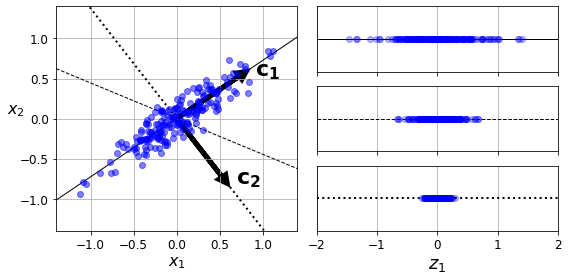

Figure 8-7


In [2]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0], [0, 1]])) #Stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) #Rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X.dot(u1.reshape(-1, 1)) 
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8, 4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=1)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=1)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, head_length=0.1,
          length_includes_head=True, fc="k", ec="k")
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, head_length=0.1,
          length_includes_head=True, fc="k", ec="k")
plt.text(u1[0] + 0.1, u1[1] -0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", rotation=0, fontsize=16)
plt.grid(True)

plt.subplot2grid((3, 2), (0, 1),)
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$z_1$", fontsize=18)
plt.axis([-2, 2, -1, 1])
plt.grid(True)

save_fig("Dimensionality reduction - Selecting the subspace to project on")
plt.show()
print("Figure 8-7")

##### Principal components

**PCA identifies the axis that acconts for the most variance in the training set.** In figure 8-7, its the solid line. **It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of remaining variance.** If it were a higher-dimensional dataset, PCA would keep on finding other axes that are orthogonol to previous axes - as many as the number of dimensions in the dataset

The $i^{th}$ axis is called the $i^{th}$ _principal component_ (PC) of the data. In figure 8-7, the first PC is the axis in which vector $c_1$ lies, and the second PC is the axis in which vector $c_2$ lies

**So how can you find the principal components of a training set?**

There's a standard matrix factorization technique called ***Singular Value Decomposition*** (SVD) that can decompose the training set matrix $X$ into the matrix multiplication of three matrices $U \sum V^T$, where $V$ contains the unit vectors that define all the principal components that we're looking for (equation 8-1)

- $U$ - An $m \times n$ matrix. The columns are called _left singular vectors_
- $\sum$ - An $n \times n$ diagonal matrix. The elements are only nonzero on the diagonal, and are called _singular values_
- $V^t$ - An $n \times n$ matrix. The rows contain the elements of _right singular vectors_

<img src="images/Dimensionality reduction - PCA, principal component matrix.png">

Let's first build a 3D dataset and then use Numpy's _svd()_ function to obtain all the principal components of the training set, then extracts the two unit vectors that define the first 2 PCs

Build 3D dataset:

In [3]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 -0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w1 + noise * np.random.randn(m)

In [4]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [5]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [6]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

> PCA assumes that the dataset is centered around the origin. Scikit Learn's PCA classes takes care of that. If you **implement PCA by yourself, like in the preceding example, or use other libararies, don't forget to center the data**

##### Projecting down to d dimensions

The next step, after identifying all the principal components, is reducing the dimensionality of the dataset down to ***d*** dimensions by porjecting it onto the hyperplane defined by the first _d_ PC (principal component). This hyperplane ensures that the projection will preserve as much variance as possible

To project the training set onto the hyperplane and obtain a reduced dataset $X_d-proj$ of dimensionality ***d***:
- Compute the matrix multiplication of the training set matrix $X$ by the matrix $W_d$
    - $W_d$ is defined as the matrix containing the first ***d*** columns of $V$, as shown in equation 8-2

<img src="images/Dimensionality reduction - PCA, projecting the training set down to d dimensions.png">

Let's project the training set onto the plane defined by the first 2 PC's

In [7]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [8]:
X2D_using_svd = X2D

The **process above** shows how to reduce the dimensionality of any dataset down to any number of dimensions, while preserving as much variance as possible

##### Using Scikit Learn

Scikit Learn's PCA class uses SVD decomposition to implement PCA, just as we did earlier. Let's apply PCA to reduce the dimensionality of the dataset down to 2 dimensions (Scikit Learn automatically takes care of centering the data)

In [9]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

After fitting PCA transformer to the dataset, its ***components_*** attribute holds the transpose of $w_d$ (e.g, the unit vector that defines the first principal component is equal to ***pca.components_.T[:, 0]***)

In [10]:
X2D[:5]

array([[ 1.23139275,  0.41881395],
       [-0.0703487 , -0.37067823],
       [ 1.1473837 ,  0.35635335],
       [ 0.90073606, -0.28475069],
       [ 0.74472406, -0.20230269]])

In [11]:
X2D_using_svd[:5]

array([[-1.23139275, -0.41881395],
       [ 0.0703487 ,  0.37067823],
       [-1.1473837 , -0.35635335],
       [-0.90073606,  0.28475069],
       [-0.74472406,  0.20230269]])

**Note**, running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. **In the exmpale above, PCA using Scikit Learn gives the same projections as the one given by the SVD approach, except both axes are flipped**

In [12]:
np.allclose(X2D, -X2D_using_svd)

True

Recover the 3D points projected on the plane (PCA 2D subspace)

In [13]:
X3D_inv = pca.inverse_transform(X2D)

You should take into account that some information loss occured during the projection step (from 3D to 2D subspace), so the recovered 3D points aren't exactly equal to the original 3D point

In [14]:
np.allclose(X3D_inv, X)

False

Let's compute the reconstruction error

In [15]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.01106161829593676

**The inverse transform in the SVD approach looks like this**

In [16]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

The reconstruction from both methods aren't identical because Scikit Learn's PCA class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction

In [17]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

As stated above, after PCA's fit_transform the dataset, PCA object gives access to the PC's (principal component) that it computed

In [18]:
pca.components_

array([[-0.94762989, -0.29402842, -0.12467913],
       [ 0.30510395, -0.94884017, -0.08132593]])

Compare to the first two PC's (principal component) computed using SVD method

In [19]:
Vt[:2]

array([[ 0.94762989,  0.29402842,  0.12467913],
       [-0.30510395,  0.94884017,  0.08132593]])

**Notice that the axes are flipped**

##### Explained variance ration

PCA class also offers the ***explained_variance_ratio_*** variable. The ration indicates the proportion of the dataset's variance that lies along each PC (prinicipal component). 

Let's look at the explained variance rations of the first 2 components of the 3D dataset represented in figure 8-2

In [20]:
pca.explained_variance_ratio_

array([0.84720206, 0.14032689])

The first dimension explains 91.69% of the variance, while the second explains 8.29%

By projecting down to 2D, we lost about 0.02% (1 - (91.69 + 8.29)) variance

In [21]:
#1 -pca.explained_variance_ratio_.sum().

Let's compute the explained variance ratio using the SVD approach (recall that s is the diagonal of the matrix S)

In [22]:
np.square(s) / np.square(s).sum()

array([0.84720206, 0.14032689, 0.01247105])

Now, we'll plot figures for the **projection sections**

Utility class to draw 3D arrows (copied from http://stackoverflow.com/questions/11140163)

In [23]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d =  xs, ys, zs
    
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

Express the plane as a function of x and y

In [24]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Plot the 3D dataset, the plane and the projections on the plane

Saving figure Dimensionality reduction - Projection, 3D dataset lying close to a 2D subspace


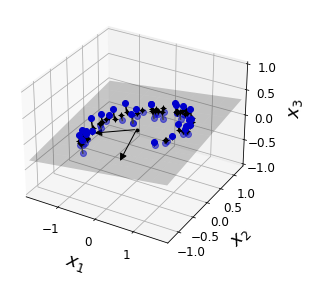

Figure 8-2


In [25]:
fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection="3d")

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("Dimensionality reduction - Projection, 3D dataset lying close to a 2D subspace")
plt.show()
print("Figure 8-2")

Saving figure Dimensionality reduction - Projection, new 2D dataset after projection
Figure 8-3


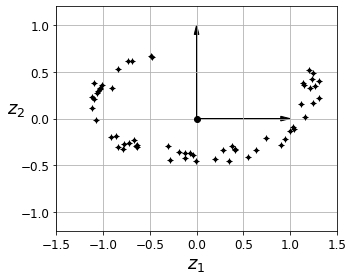

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")

plt.plot(X2D[:, 0], X2D[:, 1], "k+")
plt.plot(X2D[:, 0], X2D[:, 1], "k.")
plt.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, head_length=0.1, length_includes_head=True,
        fc="k", ec="k")
ax.arrow(0, 0, 1, 0, head_width=0.05, head_length=0.1, length_includes_head=True,
        fc="k", ec="k")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", rotation=0, fontsize=18)
plt.axis([-1.5, 1.5, -1.2, 1.2])
plt.grid(True)
save_fig("Dimensionality reduction - Projection, new 2D dataset after projection")
print("Figure 8-3")

Now, we'll plot figures for the **manifold learning sections**